# 이미지 데이터 전처리

여러분께서는 제가 만들어놓은 사전 데이터에 kaggle 데이터를 직접 다운 받으셔서 이미지를 결합하는 작업을 해서야합니다. 

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("victorcallejasf/multimodal-hate-speech")

print("Path to dataset files:", path)

약 6G정도의 데이터를 다운 받습니다.  
약 1분정도 소요됩니다. 

앞서 전처리 코드를 모두 따라 오신 분들은 이 코드를 실행하실 필요없습니다. 

In [ ]:
# kaggle 데이터셋은 다른 폴더에 저장되어 있기에 폴더를 이동
!mv /root/.cache/kagglehub/datasets/victorcallejasf/multimodal-hate-speech/versions/1 /workspace/FASTCAMPUS-CH09_11/chapter09-Multi_Modal/

# 폴더명을 1에서 kaggle_data로 변경
!mv ./1 ./kaggle_data

# kaggle_data도 github에 따로 저장하지 않기에 .gitignore에 추가
!echo "kaggle_data" >> .gitignore

In [1]:
import pandas as pd 

# 사전에 준비해둔 파일 불러오기 
df = pd.read_csv("./data/final_df.csv")

In [2]:
df.head(2)

,index,file_id,img_url,labels,tweet_url,tweet_text,labels_str,file_path,is_hate,original,translated
0,11872,1106904873637953537,http://pbs.twimg.com/tweet_video_thumb/D1yEG7V...,"[0, 0, 0]",https://twitter.com/user/status/11069048736379...,Also woke up to this nigga asking me out on a ...,"['NotHate', 'NotHate', 'NotHate']",./kaggle_data/img_resized/1106904873637953537.jpg,False,Also woke up to this nigga asking me out on a ...,또한 이 놈이 나한테 데이트하자고 하는 걸 깨웠어... 하지만 아니야. 나는 더 이...
1,381,1108495255819730945,http://pbs.twimg.com/media/D2Iqj05X0AAzksK.jpg,"[0, 0, 0]",https://twitter.com/user/status/11084952558197...,#RNS REAL NIGGA SHIT,"['NotHate', 'NotHate', 'NotHate']",./kaggle_data/img_resized/1108495255819730945.jpg,False,#RNS REAL NIGGA SHIT,#RNS REAL NIGGA SHIT


In [3]:
# True, False를 0과 1로 변경 
df["is_hate"] = df["is_hate"].astype(int)

# 0,0,0 ... 데이터, 1,1,1 ... 데이터 이런 순서로 구성되어 있기에 데이터 프레임 섞기
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [4]:
from datasets import Dataset
hf_dataset = Dataset.from_pandas(df)


    0: "NotHate",    # 혐오가 아님  
    1: "Racist",     # 인종차별  
    2: "Sexist",     # 성차별  
    3: "Homophobe",  # 성소수자 혐오  
    4: "Religion",   # 종교 관련 혐오  
    5: "OtherHate"   # 기타 혐오  


유해성을 판별하기 위한 모델을 만들려고 합니다.  
이에, 맞는 시스템 프롬프트와 프롬프트를 아래와 같이 작성합니다.  

In [5]:
system_message = "당신은 이미지와 텍스트의 '유해성(harmfulness)'을 판별하는 분류 모델입니다."

prompt = """입력으로 이미지 또는 ###텍스트가 주어지면, 해당 콘텐츠가 유해한지 여부를 "1" 또는 "0"으로 출력하세요.
- 출력은 반드시 숫자 하나만(문자열 없이) 출력합니다.
  - "1" : 유해(혐오·차별·폭력·선정성·기타 해악 가능성이 있다고 판단되는 경우)
  - "0" : 비유해(문제 없다고 판단되는 경우)
유해성(harmfulness)을 판단할 때는 아래 항목을 포함해 검토하세요:
1. **혐오 표현 (Hate Speech)**  
   - 인종, 성별, 종교, 성적 지향, 장애 등을 근거로 특정 집단/개인을 비하·모욕·차별하는 언어/이미지
   - 명백한 증오, 차별, 폭력 조장 등
2. **직접적인 폭력·잔혹 행위**  
   - 극단적인 폭력 묘사(살해·자해·테러 등)
   - 노골적으로 잔혹하거나 충격적인 내용
3. **노골적 성적 콘텐츠**  
   - 명백히 선정적·음란한 묘사, 아동 성착취 등 불법적이거나 심각한 윤리적 문제가 있는 경우
4. **사생활 침해, 불법 행위 조장**  
   - 명백한 사생활 침해, 범죄 또는 불법 행위를 조장하는 내용
5. **기타 위험 요소**  
   - 위 항목 외에도, 사회적으로 유해하거나 심각한 해악을 유발할 수 있는 이미지·텍스트
만약 콘텐츠가 위 기준 중 하나라도 충족하여 "유해"하다고 판단되면 "1"을,  
해당되지 않으면 "0"을 출력하십시오.
출력은 오직 숫자 하나(1 또는 0)만 반환하고, 어떠한 추가 문구나 설명도 첨부하지 마십시오.

###텍스트 :{text}"""

In [6]:
from datasets import load_dataset

# 데이터셋을 OpenAI 메시지 형식으로 변환하는 함수      
def format_data(sample):
   return {"messages": [
               {
                   "role": "system", # 시스템 역할
                   "content": [{"type": "text", "text": system_message}], # 시스템 메시지
               },
               {
                   "role": "user",  # 사용자 역할
                   "content": [
                       {
                           "type": "text",
                           # 제품명과 카테고리를 포함한 프롬프트 생성
                           "text": prompt.format(text=sample["translated"]),
                       },
                       {
                           "type": "image", # 이미지 타입
                           "image": sample["file_path"], # 제품 이미지
                       }
                   ],
               },
               {
                   "role": "assistant", # AI 어시스턴트 역할
                   "content": [{"type": "text", "text": sample["is_hate"]}], # 제품 설명
               },
           ],
       }


dataset = [format_data(sample) for sample in hf_dataset]

In [7]:
hf_dataset[100]

{'index': 131245,
 'file_id': 1113508125670293504,
 'img_url': 'http://pbs.twimg.com/media/D3P5vJWWkAEUw0a.jpg',
 'labels': '[3, 3, 2]',
 'tweet_url': 'https://twitter.com/user/status/1113508125670293504',
 'tweet_text': 'Fucking faggot',
 'labels_str': "['Homophobe', 'Homophobe', 'Sexist']",
 'file_path': './kaggle_data/img_resized/1113508125670293504.jpg',
 'is_hate': 1,
 'original': 'Fucking faggot',
 'translated': '젠장 같은 애송이'}

In [8]:
dataset[0]

{'messages': [{'role': 'system',
   'content': [{'type': 'text',
     'text': "당신은 이미지와 텍스트의 '유해성(harmfulness)'을 판별하는 분류 모델입니다."}]},
  {'role': 'user',
   'content': [{'type': 'text',
     'text': '입력으로 이미지 또는 ###텍스트가 주어지면, 해당 콘텐츠가 유해한지 여부를 "1" 또는 "0"으로 출력하세요.\n- 출력은 반드시 숫자 하나만(문자열 없이) 출력합니다.\n  - "1" : 유해(혐오·차별·폭력·선정성·기타 해악 가능성이 있다고 판단되는 경우)\n  - "0" : 비유해(문제 없다고 판단되는 경우)\n유해성(harmfulness)을 판단할 때는 아래 항목을 포함해 검토하세요:\n1. **혐오 표현 (Hate Speech)**  \n   - 인종, 성별, 종교, 성적 지향, 장애 등을 근거로 특정 집단/개인을 비하·모욕·차별하는 언어/이미지\n   - 명백한 증오, 차별, 폭력 조장 등\n2. **직접적인 폭력·잔혹 행위**  \n   - 극단적인 폭력 묘사(살해·자해·테러 등)\n   - 노골적으로 잔혹하거나 충격적인 내용\n3. **노골적 성적 콘텐츠**  \n   - 명백히 선정적·음란한 묘사, 아동 성착취 등 불법적이거나 심각한 윤리적 문제가 있는 경우\n4. **사생활 침해, 불법 행위 조장**  \n   - 명백한 사생활 침해, 범죄 또는 불법 행위를 조장하는 내용\n5. **기타 위험 요소**  \n   - 위 항목 외에도, 사회적으로 유해하거나 심각한 해악을 유발할 수 있는 이미지·텍스트\n만약 콘텐츠가 위 기준 중 하나라도 충족하여 "유해"하다고 판단되면 "1"을,  \n해당되지 않으면 "0"을 출력하십시오.\n출력은 오직 숫자 하나(1 또는 0)만 반환하고, 어떠한 추가 문구나 설명도 첨부하지 마십시오.\n\n###텍스트 :"왜냐면 니가 슬라이드할 거면 P**SY NIGGA, 그

In [9]:
from sklearn.model_selection import train_test_split

# test_size=0.1로 설정하여 전체 데이터의 10%를 테스트 세트로 분리
train_dataset, test_dataset = train_test_split(dataset, 
                                             test_size=0.1, 
                                             random_state=42)

In [10]:
train_dataset[0]

{'messages': [{'role': 'system',
   'content': [{'type': 'text',
     'text': "당신은 이미지와 텍스트의 '유해성(harmfulness)'을 판별하는 분류 모델입니다."}]},
  {'role': 'user',
   'content': [{'type': 'text',
     'text': '입력으로 이미지 또는 ###텍스트가 주어지면, 해당 콘텐츠가 유해한지 여부를 "1" 또는 "0"으로 출력하세요.\n- 출력은 반드시 숫자 하나만(문자열 없이) 출력합니다.\n  - "1" : 유해(혐오·차별·폭력·선정성·기타 해악 가능성이 있다고 판단되는 경우)\n  - "0" : 비유해(문제 없다고 판단되는 경우)\n유해성(harmfulness)을 판단할 때는 아래 항목을 포함해 검토하세요:\n1. **혐오 표현 (Hate Speech)**  \n   - 인종, 성별, 종교, 성적 지향, 장애 등을 근거로 특정 집단/개인을 비하·모욕·차별하는 언어/이미지\n   - 명백한 증오, 차별, 폭력 조장 등\n2. **직접적인 폭력·잔혹 행위**  \n   - 극단적인 폭력 묘사(살해·자해·테러 등)\n   - 노골적으로 잔혹하거나 충격적인 내용\n3. **노골적 성적 콘텐츠**  \n   - 명백히 선정적·음란한 묘사, 아동 성착취 등 불법적이거나 심각한 윤리적 문제가 있는 경우\n4. **사생활 침해, 불법 행위 조장**  \n   - 명백한 사생활 침해, 범죄 또는 불법 행위를 조장하는 내용\n5. **기타 위험 요소**  \n   - 위 항목 외에도, 사회적으로 유해하거나 심각한 해악을 유발할 수 있는 이미지·텍스트\n만약 콘텐츠가 위 기준 중 하나라도 충족하여 "유해"하다고 판단되면 "1"을,  \n해당되지 않으면 "0"을 출력하십시오.\n출력은 오직 숫자 하나(1 또는 0)만 반환하고, 어떠한 추가 문구나 설명도 첨부하지 마십시오.\n\n###텍스트 :니가가 뭐야 네 이름이 뭐냐고 물어봤는데 그거 진짜 짜증

In [11]:
print("학습 데이터 :", len(train_dataset))
print("테스트 데이터 :", len(test_dataset))

학습 데이터 : 2093
테스트 데이터 : 233


여기까지 준비하면 이미지 데이터 전처리가 모두 끝이 납니다. 

# 학습 - 파인튜닝(1)

In [12]:
import torch
from transformers import AutoModelForVision2Seq, AutoProcessor

# 허깅페이스 모델 ID
model_id = "Qwen/Qwen2-VL-7B-Instruct" 

# 모델과 프로세서 로드
model = AutoModelForVision2Seq.from_pretrained(
   model_id,
   device_map="auto",                            # GPU 메모리에 자동 할당
   torch_dtype=torch.bfloat16,                   # bfloat16 정밀도 사용
)
processor = AutoProcessor.from_pretrained(model_id)  # 텍스트/이미지 전처리기 로드

Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'mrope_section'}
`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

기존 언어모델을 사용하실 때는 AutoModelForCausalLM를 사용하셨습니다. 

* from transformers import AutoModelForVision2Seq, AutoProcessor: Hugging Face의 Transformers 라이브러리에서 두 클래스를 임포트합니다.
    *  AutoModelForVision2Seq: 이미지와 텍스트를 입력받아 시퀀스(문장 등)를 출력하는 모델을 불러올 때 사용합니다.
    * AutoProcessor: 텍스트와 이미지 데이터에 대한 전처리를 자동으로 처리해주는 도구입니다.

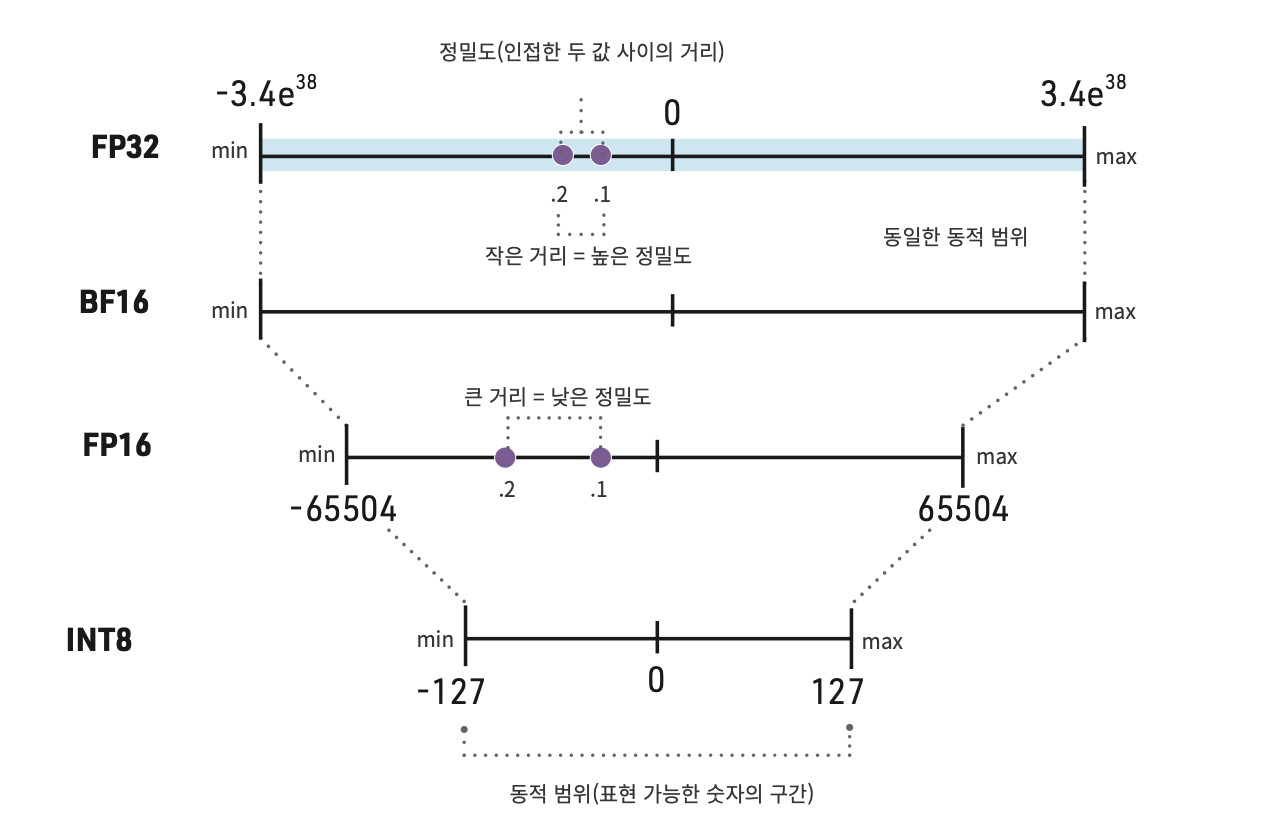

어떻게 각 데이터타입별로 표현할 수 있는 숫자의 범위가 달라지는 것일까요? 

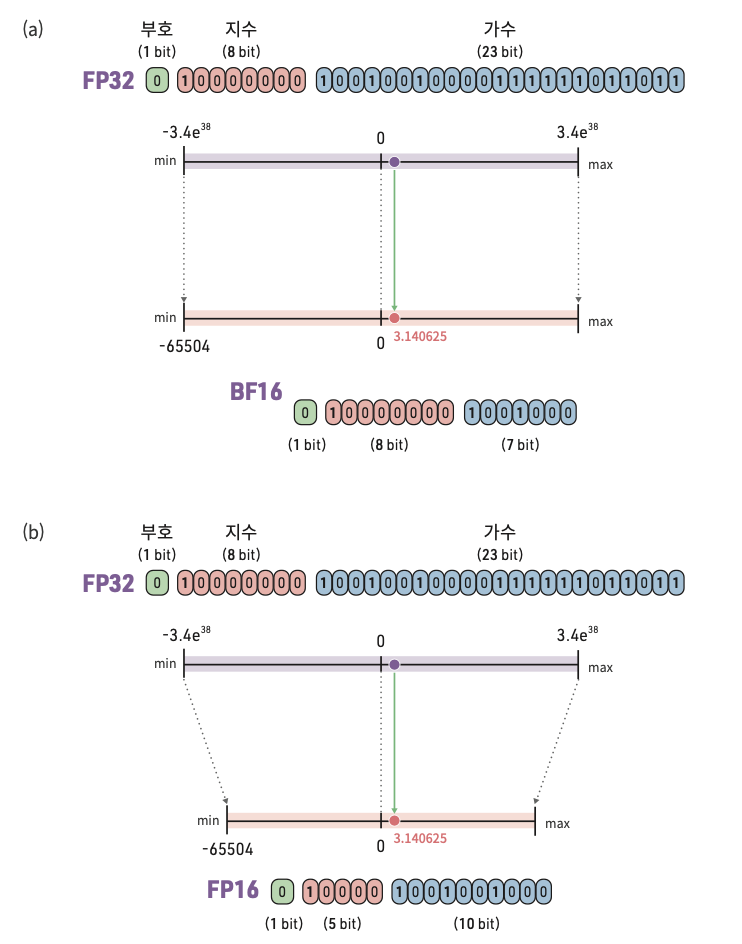

* FP16은 지수 부분을 8비트에서 5비트로 줄여 표현할 수 있는 숫자의 범위가 크게 축소됐습 니다. 이로 인해 FP16으로는 최대 ±65504까지만 표현할 수 있게 됐습니다. 반면, BF16은 FP32와 동일한 8비트의 지수를 유지하면서 가수만 23비트에서 7비트로 축소했습니다. 이 러한 접근 방식 덕분에 BF16은 FP32와 동일한 ±3.4e38의 넓은 범위를 그대로 유지할 수 있었습니다.
* BF16은 숫자를 매우 정밀하게 표현하는 능력은 일부 포기하는 대신, 매우 크거나 작은 숫 자도 표현할 수 있게 했습니다. 
* 즉, BF16은 FP32만큼 다양한 크기의 숫자를 다룰 수 있으 면서도 메모리 사용량을 줄이고 계산 속도도 향상할 수 있는 데이터 타입입니다.

입력으로 들어갈 데이터를 점검해보겠습니다. 

In [13]:
train_dataset[246]["messages"]

[{'role': 'system',
  'content': [{'type': 'text',
    'text': "당신은 이미지와 텍스트의 '유해성(harmfulness)'을 판별하는 분류 모델입니다."}]},
 {'role': 'user',
  'content': [{'type': 'text',
    'text': '입력으로 이미지 또는 ###텍스트가 주어지면, 해당 콘텐츠가 유해한지 여부를 "1" 또는 "0"으로 출력하세요.\n- 출력은 반드시 숫자 하나만(문자열 없이) 출력합니다.\n  - "1" : 유해(혐오·차별·폭력·선정성·기타 해악 가능성이 있다고 판단되는 경우)\n  - "0" : 비유해(문제 없다고 판단되는 경우)\n유해성(harmfulness)을 판단할 때는 아래 항목을 포함해 검토하세요:\n1. **혐오 표현 (Hate Speech)**  \n   - 인종, 성별, 종교, 성적 지향, 장애 등을 근거로 특정 집단/개인을 비하·모욕·차별하는 언어/이미지\n   - 명백한 증오, 차별, 폭력 조장 등\n2. **직접적인 폭력·잔혹 행위**  \n   - 극단적인 폭력 묘사(살해·자해·테러 등)\n   - 노골적으로 잔혹하거나 충격적인 내용\n3. **노골적 성적 콘텐츠**  \n   - 명백히 선정적·음란한 묘사, 아동 성착취 등 불법적이거나 심각한 윤리적 문제가 있는 경우\n4. **사생활 침해, 불법 행위 조장**  \n   - 명백한 사생활 침해, 범죄 또는 불법 행위를 조장하는 내용\n5. **기타 위험 요소**  \n   - 위 항목 외에도, 사회적으로 유해하거나 심각한 해악을 유발할 수 있는 이미지·텍스트\n만약 콘텐츠가 위 기준 중 하나라도 충족하여 "유해"하다고 판단되면 "1"을,  \n해당되지 않으면 "0"을 출력하십시오.\n출력은 오직 숫자 하나(1 또는 0)만 반환하고, 어떠한 추가 문구나 설명도 첨부하지 마십시오.\n\n###텍스트 :내 말을 들어봐, NIGGA'},
   {'type': 'image',
    'imag

text 내용 : NIGGA라는 흑인을 혐오하는 표현이 트윗글이 적혀있습니다. 

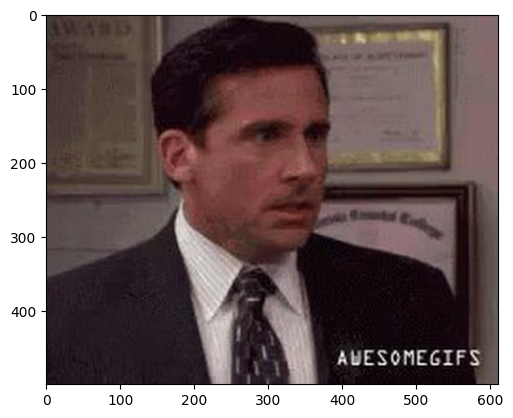

In [14]:
# 이미지 확인 
import matplotlib.pyplot as plt
random_image = plt.imread('./kaggle_data/img_resized/1110399824229265408.jpg')
plt.imshow(random_image)

앞서 살펴봤던 Chat Template을 실제로 직접 적용해보겠습니다.  
Chat Template을 적용하는 것은 어렵지 않습니다.  
processor에 내재된 apply_chat_template을 사용하면 바로 messages가 caht_template으로 변경됩니다. 

In [15]:
text = processor.apply_chat_template(
    train_dataset[246]["messages"], tokenize=False, add_generation_prompt=False
)
print(text)

<|im_start|>system
당신은 이미지와 텍스트의 '유해성(harmfulness)'을 판별하는 분류 모델입니다.<|im_end|>
<|im_start|>user
입력으로 이미지 또는 ###텍스트가 주어지면, 해당 콘텐츠가 유해한지 여부를 "1" 또는 "0"으로 출력하세요.
- 출력은 반드시 숫자 하나만(문자열 없이) 출력합니다.
  - "1" : 유해(혐오·차별·폭력·선정성·기타 해악 가능성이 있다고 판단되는 경우)
  - "0" : 비유해(문제 없다고 판단되는 경우)
유해성(harmfulness)을 판단할 때는 아래 항목을 포함해 검토하세요:
1. **혐오 표현 (Hate Speech)**  
   - 인종, 성별, 종교, 성적 지향, 장애 등을 근거로 특정 집단/개인을 비하·모욕·차별하는 언어/이미지
   - 명백한 증오, 차별, 폭력 조장 등
2. **직접적인 폭력·잔혹 행위**  
   - 극단적인 폭력 묘사(살해·자해·테러 등)
   - 노골적으로 잔혹하거나 충격적인 내용
3. **노골적 성적 콘텐츠**  
   - 명백히 선정적·음란한 묘사, 아동 성착취 등 불법적이거나 심각한 윤리적 문제가 있는 경우
4. **사생활 침해, 불법 행위 조장**  
   - 명백한 사생활 침해, 범죄 또는 불법 행위를 조장하는 내용
5. **기타 위험 요소**  
   - 위 항목 외에도, 사회적으로 유해하거나 심각한 해악을 유발할 수 있는 이미지·텍스트
만약 콘텐츠가 위 기준 중 하나라도 충족하여 "유해"하다고 판단되면 "1"을,  
해당되지 않으면 "0"을 출력하십시오.
출력은 오직 숫자 하나(1 또는 0)만 반환하고, 어떠한 추가 문구나 설명도 첨부하지 마십시오.

###텍스트 :내 말을 들어봐, NIGGA<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant
1<|im_end|>



In [16]:
# apply_chat_template에 있는 다양한 기능 
# add_generation_prompt를 True로 설정할 경우, 
temp_text = processor.apply_chat_template(
    train_dataset[246]["messages"], tokenize=False, add_generation_prompt=True
)
print(temp_text)

<|im_start|>system
당신은 이미지와 텍스트의 '유해성(harmfulness)'을 판별하는 분류 모델입니다.<|im_end|>
<|im_start|>user
입력으로 이미지 또는 ###텍스트가 주어지면, 해당 콘텐츠가 유해한지 여부를 "1" 또는 "0"으로 출력하세요.
- 출력은 반드시 숫자 하나만(문자열 없이) 출력합니다.
  - "1" : 유해(혐오·차별·폭력·선정성·기타 해악 가능성이 있다고 판단되는 경우)
  - "0" : 비유해(문제 없다고 판단되는 경우)
유해성(harmfulness)을 판단할 때는 아래 항목을 포함해 검토하세요:
1. **혐오 표현 (Hate Speech)**  
   - 인종, 성별, 종교, 성적 지향, 장애 등을 근거로 특정 집단/개인을 비하·모욕·차별하는 언어/이미지
   - 명백한 증오, 차별, 폭력 조장 등
2. **직접적인 폭력·잔혹 행위**  
   - 극단적인 폭력 묘사(살해·자해·테러 등)
   - 노골적으로 잔혹하거나 충격적인 내용
3. **노골적 성적 콘텐츠**  
   - 명백히 선정적·음란한 묘사, 아동 성착취 등 불법적이거나 심각한 윤리적 문제가 있는 경우
4. **사생활 침해, 불법 행위 조장**  
   - 명백한 사생활 침해, 범죄 또는 불법 행위를 조장하는 내용
5. **기타 위험 요소**  
   - 위 항목 외에도, 사회적으로 유해하거나 심각한 해악을 유발할 수 있는 이미지·텍스트
만약 콘텐츠가 위 기준 중 하나라도 충족하여 "유해"하다고 판단되면 "1"을,  
해당되지 않으면 "0"을 출력하십시오.
출력은 오직 숫자 하나(1 또는 0)만 반환하고, 어떠한 추가 문구나 설명도 첨부하지 마십시오.

###텍스트 :내 말을 들어봐, NIGGA<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant
1<|im_end|>
<|im_start|>assistant



In [17]:
# apply_chat_template에 있는 다양한 기능 
# tokenize를 True로 설정할 경우, 
temp_text = processor.apply_chat_template(
    train_dataset[246]["messages"], tokenize=True, add_generation_prompt=True
)
print(temp_text)

[151644, 8948, 198, 64795, 82528, 33704, 90667, 21329, 80573, 10764, 44104, 53189, 20401, 364, 125522, 33883, 32831, 3203, 2178, 30414, 21636, 17877, 140568, 126591, 42905, 128618, 97929, 54070, 142713, 78952, 13, 151645, 198, 151644, 872, 198, 43866, 28754, 42039, 90667, 21329, 129549, 16600, 144153, 53189, 19969, 55673, 31079, 21329, 32290, 11, 94613, 3315, 121, 246, 144137, 142852, 19969, 126310, 33883, 23573, 21329, 83518, 63089, 18411, 330, 16, 1, 129549, 330, 15, 1, 42039, 61126, 91145, 624, 12, 61126, 33704, 141762, 69192, 92187, 125703, 72553, 7, 51588, 25715, 53955, 46682, 12802, 8, 61126, 60838, 624, 220, 481, 330, 16, 1, 549, 126310, 33883, 7, 144324, 57268, 13935, 125625, 126591, 13935, 135257, 28754, 13935, 125519, 29281, 32831, 13935, 20487, 125166, 60716, 131893, 95351, 137032, 137119, 140569, 128841, 49052, 340, 220, 481, 330, 15, 1, 549, 73986, 125522, 33883, 7, 51588, 37087, 130671, 34395, 140569, 128841, 49052, 340, 125522, 33883, 32831, 3203, 2178, 30414, 8, 17877, 

인퍼런스 함수를 미리 만들어놓겠습니다. 

In [18]:
from qwen_vl_utils import process_vision_info

# 모델 답변을 생성하는 함수
def generate_description(messages, model, processor):
   # 추론을 위한 준비
   text = processor.apply_chat_template(
       messages, tokenize=False, add_generation_prompt=True
   )
   image_inputs, video_inputs = process_vision_info(messages)
   inputs = processor(
       text=[text],
       images=image_inputs,
       videos=video_inputs,
       padding=True,
       return_tensors="pt",
   )
   inputs = inputs.to(model.device)
   # 추론: 출력 생성
   generated_ids = model.generate(
      **inputs,            # 앞서 만든 전처리 결과(토큰, 이미지, 비디오 텐서 등)를 전달
      max_new_tokens=128,  # 최대 128토큰 새롭게 생성 
      top_p=0.95,          # 상위 95% 누적 확률에 속하는 후보만 고려하는 Top-p 샘플링
      do_sample=True,      # 확률적 샘플링을 활성화하여 답변을 생성(좀 더 랜덤성을 포함하게 됨)    
      temperature=0.1      # 값이 낮을수록 보수적인(가장 확률 높은 후보에 집중) 출력을 생성하고, 높으면 다양한 출력을 시도
      )
   
   # 모델이 생성한 시퀀스에는 원본 입력 토큰 + 새로 생성된 토큰이 함께 있음 
   # len(in_ids)만큼 잘라내고 나머지 토큰만 가져옴으로써, 새로 생성된 토큰 부분만 분리
   generated_ids_trimmed = [
      out_ids[len(in_ids) :] 
      for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
   # 숫자들을 다시 우리가 인식할 수 있는 글자로 변환 
   output_text = processor.batch_decode(
       generated_ids_trimmed, 
       skip_special_tokens=True,              # 모델 내부적으로 사용하는 특수 토큰을 제거
       clean_up_tokenization_spaces=False     # 토크나이저는 텍스트를 토큰으로 변환할 때, 단어 사이의 공백이나 구두점 처리 등에서 추가적인 공백이 생길 수 있는데, 이를 제거할 것인 말지를 결정함
   )
   return output_text[0]

## process_vision_info에서 이미지가 들어가면

- **1단계: 시각 정보 추출**
  - conversations 데이터에서 extract_vision_info 함수를 호출하여, 이미지 관련 항목("image" 또는 "image_url"이 포함된 요소)을 모두 추출합니다.

- **2단계: 이미지 처리**
  - 추출된 각 vision_info 항목에 대해:
    - **이미지 여부 확인**:
      - 항목에 "image" 또는 "image_url" 키가 있는지 확인합니다.
    - **fetch_image 함수 호출**:
      - 해당 항목을 fetch_image 함수에 전달하여 이미지를 불러옵니다.
      - fetch_image 내부에서는:
        - 이미지 소스를 확인하고(PIL 객체, URL, 파일 경로, base64 문자열 등) 올바른 방식으로 이미지를 로드합니다.
        - 로드한 이미지가 RGBA 모드인 경우 to_rgb 함수를 사용해 RGB 이미지로 변환합니다.
        - smart_resize 함수를 통해, 이미지의 크기를 factor 배수로 맞추고 픽셀 수 범위(min_pixels ~ max_pixels)를 충족하도록 적절한 크기로 조정합니다.
        - 최종적으로 resize된 이미지를 반환합니다.
    - **리스트에 추가**:
      - 반환된 이미지를 image_inputs 리스트에 추가합니다.

- **3단계: 최종 반환**
  - 이미지 관련 vision_info가 하나도 없으면 image_inputs를 None으로 처리합니다.
  - (비디오 정보도 동일한 방식으로 처리되지만, 여기서는 이미지에 초점을 맞춤)
  - 최종적으로 전처리된 이미지 리스트(image_inputs)와 (필요한 경우 추가 비디오 관련 정보)를 튜플 형태로 반환합니다.

In [19]:
# 실제로 하나 메세지만 테스트 
messages =  train_dataset[246]["messages"]
answer = train_dataset[246]["messages"][2]["content"][0]["text"]
base_description = generate_description(messages, model, processor)
print("예측 결과 :", base_description)
print("정답 결과 :", answer)

예측 결과 : 1
정답 결과 : 1


In [20]:
# 모든 test_dataset에 대해 테스트를 진행하여 성능 구하기 
from tqdm.auto import tqdm 
no_train_result = [] 

for idx in tqdm(range(len(test_dataset))):
    messages =  test_dataset[idx]["messages"]
    answer = test_dataset[idx]["messages"][2]["content"][0]["text"]
    base_description = generate_description(messages, model, processor)
    no_train_result.append((answer, base_description))

  0%|          | 0/233 [00:00<?, ?it/s]

In [21]:
prediction_result = [int(predict) == int(answer) for predict, answer in no_train_result]
before_train_accuracy = sum(prediction_result) /  len(prediction_result) * 100
print(f"학습 전 정확도 : {before_train_accuracy:.2f}%") 

학습 전 정확도 : 66.09%


67%의 정확도가 나온다는 것은 모델이 어느 정도 혐오 데이터에 대해 기본적인 정보를 가지고 있다고 볼 수 있습니다.   
그러나, 저희는 더 정확한 성능을 내야하기 때문에 Fine-Tuning을 진행해보겠습니다. 

# LoRA 설정

In [22]:
from peft import LoraConfig

peft_config = LoraConfig(
        lora_alpha=16,                       # LoRA 업데이트에서 적용되는 스케일링 값 
        lora_dropout=0.05,                   # LoRA 모듈에 적용되는 드롭아웃 확률
        r=8,                                 # 저랭크 분해(rank)를 나타내며, 업데이트 행렬을 두 개의 저차원 행렬로 분해할 때의 차원 수
        bias="none",                         # LoRA 적용 시 bias 파라미터를 조정하지 않겠다는 설정
        target_modules=["q_proj", "v_proj"], # LoRA를 적용할 모델 내부의 특정 모듈(레이어) 지정
        task_type="CAUSAL_LM",               # "CAUSAL_LM"은 인과 관계 기반 언어 모델링(autoregressive language modeling)을 의미하며, 주로 텍스트 생성 작업에 사용
)

# 학습 - 파인튜닝(2)

# SFT 설정


#### 1. SFT(Supervised Fine-Tuning)란?

- **목적**:  
  대규모 사전 학습 모델을 특정 데이터셋이나 태스크(예: 질문 답변, 대화, 분류 등)에 맞게 미세 조정하여 더 좋은 성능을 내도록 하는 과정입니다. SFT에서는 일반적으로 명시적으로 주어진 입력과 그에 대응하는 정답(ground-truth label)이 있습니다. 예를 들어, 질문-답변 쌍, 번역 문장 쌍, 또는 특정 도메인의 대화 데이터 등이 이에 해당합니다. 이 데이터를 통해 모델은 입력에 대한 적절한 출력을 생성하는 법을 배우게 됩니다.
  
- **장점**:  
  - 사전 학습된 모델의 일반적 지식을 기반으로 특정 태스크에 특화된 성능을 발휘할 수 있습니다.
  - 학습 데이터가 비교적 적더라도 이미 강력한 사전 학습 모델을 활용하여 빠르게 좋은 결과를 얻을 수 있습니다.

#### 2. Hugging Face에서 SFT Train에 필요한 구성 요소

1) **SFTConfig**
- **역할**:  
  SFTConfig는 모델 파인튜닝에 필요한 모든 하이퍼파라미터와 옵션들을 한 곳에 모아둔 설정 객체입니다.  
- **포함 내용**:
  - **학습 하이퍼파라미터**: 에포크 수, 배치 사이즈, 학습률, warmup 비율, gradient accumulation 등.
  - **최적화 관련 설정**: 옵티마이저 종류, gradient clipping, gradient checkpointing 등의 메모리 및 연산 최적화 옵션.
  - **로그 및 저장 전략**: 학습 진행 상황을 로깅할 간격, 체크포인트 저장 전략, TensorBoard 설정 등.
  - **데이터셋 전처리 옵션**: 데이터셋 관련 추가 설정(예: 불필요한 열을 제거하지 않거나, 데이터셋 준비 과정을 건너뛰는 옵션 등).

- **왜 필요한가?**  
  한 곳에서 모든 설정을 관리함으로써, 학습 실험을 재현(reproducible) 가능하게 하고, 여러 실험 간의 설정 변경을 쉽게 할 수 있도록 도와줍니다. 설정 파일을 잘 관리하면 하이퍼파라미터 튜닝이나 문제 해결 시에도 유용합니다.

2) **SFTTrainer**
- **역할**:  
  SFTTrainer는 SFTConfig에 정의된 설정을 바탕으로 실제 학습 과정을 관리하고 실행하는 클래스입니다.
  
- **주요 기능**:
  - **데이터셋 로딩 및 전처리**: 설정에 따라 데이터셋을 불러오고, 필요한 경우라면 전처리 과정이 진행됩니다. 
  - **모델 업데이트**: SFTConfig에 정의된 옵티마이저와 학습률 스케줄러 등을 사용하여 모델 파라미터를 업데이트합니다.
  - **로그 기록 및 체크포인트 저장**: 학습 중 일정 주기마다 로그를 기록하고, 체크포인트를 저장하여 학습 진행 상황을 추적할 수 있도록 합니다.
  - **평가 및 검증**: 학습 과정 중 혹은 종료 후에 모델의 성능을 평가하고 검증하는 역할을 수행합니다.

- **왜 필요한가?**  
  복잡한 학습 파이프라인을 일관된 API로 관리하여, 사용자가 세부 구현에 신경 쓰지 않고 설정만 조정하여 학습을 진행할 수 있도록 합니다. 이는 실험의 효율성을 높이고, 코드의 재사용성과 유지보수성을 개선하는 데 큰 도움이 됩니다.


In [23]:
from trl import SFTConfig
from transformers import Qwen2VLProcessor
from qwen_vl_utils import process_vision_info

# SFTConfig를 통해 학습 설정을 정의
args = SFTConfig(
    output_dir="qwen2-7b-instruct-harmful-detector-2000",   # 학습된 모델과 체크포인트를 저장할 디렉터리 경로 및 리포지토리 ID
    num_train_epochs=1,                                     # 전체 학습 에포크 수 (데이터셋을 몇 번 반복할지 설정)
    per_device_train_batch_size=8,                          # 각 장비(GPU)별로 한 번에 처리할 데이터 배치 크기 (메모리와 연관됨)
    gradient_accumulation_steps=8,                          # 경사 누적 스텝 수 (이 횟수만큼 기울기를 누적한 후 업데이트)- 배치 사이즈를 효과적으로 늘리기 위해, 여러 스텝의 기울기를 누적한 후 한 번에 모델 업데이트 / 배치 사이즈 8을 8 스텝 누적하면 실제 업데이트는 64 샘플
    gradient_checkpointing=True,                            # 메모리 절약을 위한 gradient checkpointing 활성화 (메모리 최적화) - 학습 중 메모리 사용량을 줄이기 위해 중간 활성값을 저장하지 않고, 역전파 시에 재계산하는 기법
    optim="adamw_torch_fused",                              # AdamW 옵티마이저 (fused 버전 사용으로 학습 속도 향상)
    logging_steps=5,                                        # 몇 스텝마다 로그를 출력할지 설정 (여기선 5 스텝마다 로그)
    save_strategy="epoch",                                  # 매 에포크마다 체크포인트 저장 설정
    learning_rate=2e-4,                                     # 학습률 (QLoRA 논문에서 추천된 값 사용)
    bf16=True,                                              # bfloat16 정밀도 사용 (메모리 절약 및 속도 향상)
    tf32=True,                                              # tf32 정밀도 사용 (NVIDIA GPU에서 학습 속도 향상)
    max_grad_norm=0.3,                                      # 기울기 클리핑을 위한 최대 기울기 값 (QLoRA 논문에서 추천된 값) - 기울기가 너무 커지는 것을 방지
    warmup_ratio=0.03,                                      # 학습 초기에 학습률을 점진적으로 올리는 warmup 비율 (QLoRA 논문에서 추천된 값) - 학습 초기 몇 퍼센트의 스텝 동안 학습률을 점진적으로 증가시키는 warmup 비율
    lr_scheduler_type="constant",                           # 고정된 학습률 스케줄러 사용 (학습률이 변하지 않음)
    # push_to_hub=True,                                     # 학습된 모델을 Hugging Face Hub에 푸시할지 여부
    report_to="wandb",                                      # wandb를 통해 학습 상태를 모니터링
    gradient_checkpointing_kwargs={"use_reentrant": False}, # reentrant gradient checkpointing 설정 (비재진입 방식 사용)
    dataset_text_field="",                                  # 데이터셋에서 텍스트 필드를 위한 더미 필드 (collator에서 필요)
    dataset_kwargs={"skip_prepare_dataset": True}           # collator에서 데이터셋 전처리를 건너뛰기 위한 설정 - 이미 모든 전처리륻 다 진행하고 입력으로 사용하기 때문에 
)

# 불필요한 열 삭제하지 않도록 설정 (학습 중 사용되지 않는 열이라도 유지)
args.remove_unused_columns = False

* AdamW 옵티마이저:
    - 딥러닝 학습 과정에서 가중치를 업데이트할 때 사용되는 알고리즘입니다. AdamW는 일반 Adam 옵티마이저와 달리 가중치 감쇠(weight decay)를 명시적으로 적용하여, 과적합을 줄이는 데 도움이 됩니다.
        - ※ 가중치 감쇠 : 모델의 학습 과정에서 파라미터(가중치)가 너무 크게 증가하지 않도록 제어하는 정규화(regularization) 기법

* Fused의 의미:
    - 일반적인 옵티마이저는 여러 수학 연산(예를 들어, 평균, 분산 계산, 업데이트 계산 등)을 별개의 단계로 처리합니다. 그러나 fused 버전은 이 여러 단계를 하나의 연산으로 묶어 한 번에 실행함으로써:

        - 연산 오버헤드 감소: GPU와 같은 하드웨어에서는 각 연산마다 호출하는 오버헤드가 발생하는데, fused 연산은 이 오버헤드를 줄여줍니다.
        - 메모리 접근 최적화: 여러 번 메모리에 접근하는 대신, 한 번에 데이터를 읽고 처리하기 때문에 캐시 효율이 좋아집니다.
        - 전체 학습 속도 향상: 이와 같은 최적화 덕분에 동일한 하드웨어 자원에서 더 빠르게 학습을 진행할 수 있습니다.

---

### bfloat16 (bf16)

- **포맷 구조와 특징**:  
  bfloat16은 "Brain Floating Point"의 약자로, 16비트의 부동소수점 형식입니다. 표준 float16과 달리, bfloat16은 다음과 같은 구조를 갖습니다:
  - **1비트**: 부호 (Sign)
  - **8비트**: 지수 (Exponent) → 이는 FP32와 동일하여 매우 넓은 수의 범위를 커버할 수 있습니다.
  - **7비트**: 가수 (Mantissa) → 정밀도가 float32에 비해 낮습니다.

- **장점 및 활용**:  
  - **메모리 절약 및 연산 속도 개선**:  bfloat16은 32비트 대신 16비트를 사용함으로써 메모리 사용량을 절반으로 줄입니다. 이는 큰 모델이나 배치 크기가 클 때 메모리 효율성을 크게 향상시킵니다.
  - **안정적인 동적 범위**:  8비트의 지수를 사용하기 때문에 FP32와 유사한 동적 범위를 유지합니다. 이는 학습 과정에서 큰 수나 작은 수를 다룰 때 안정성을 보장합니다.
  - **딥러닝 학습 최적화**:  낮은 정밀도가 허용되는 딥러닝 연산에서, bfloat16은 충분한 표현력을 제공하면서 연산 속도를 높이고, 특히 TPU나 최신 GPU에서 지원되어 빠른 학습이 가능합니다.


### TF32 (텐서플로32)

- **포맷 구조와 목적**:  
  TF32는 NVIDIA의 Ampere 아키텍처에서 도입된 포맷으로, 기존 FP32와 비교하여 일부 정밀도를 희생하는 대신 연산 속도를 크게 향상시키는 데 목적이 있습니다. TF32는 다음과 같이 구성됩니다:
  - **1비트**: 부호 (Sign)
  - **8비트**: 지수 (Exponent) → FP32와 동일하여 수의 범위를 유지합니다.
  - **10비트**: 가수 (Mantissa) → FP32의 23비트보다 낮아 정밀도는 다소 감소합니다.

- **장점 및 활용**:  
  - **연산 속도 최적화**:  TF32는 행렬 곱셈과 같은 텐서 연산에서 특별히 최적화된 연산 모드를 사용합니다. 이를 통해 FP32 대비 훨씬 빠른 연산이 가능하며, 딥러닝 학습 시 큰 폭의 속도 향상을 제공합니다.
  - **자동 전환 및 호환성**:  NVIDIA Ampere GPU에서는 TF32가 자동으로 적용되어, 별도의 코딩 없이도 기존 FP32 연산을 TF32 모드로 실행할 수 있습니다. 이는 성능 개선을 유도하면서도 대부분의 모델에서 정확도 저하 없이 사용 가능합니다.
  - **딥러닝 특성에 최적화**:  딥러닝 모델의 경우, 약간의 정밀도 손실이 있어도 모델의 성능에 큰 영향을 주지 않는 경우가 많습니다. TF32는 이러한 특성을 고려해 설계되었으며, 실제 학습 및 추론 과정에서 효율적인 속도와 충분한 정확도를 동시에 제공합니다.

bf16, TF32 두 옵션 모두 딥러닝에서 자주 사용되는 혼합 정밀도(mixed-precision) 기법의 일부로, 모델 학습의 효율성을 높이고, 메모리 및 연산 자원을 최적화하는 데 기여합니다.  즉, bfloat16은 데이터 저장 및 전반적인 연산 정밀도를 관리하는 데이터 타입인 반면, TF32는 특정 연산 단계에서 연산 효율을 높이기 위해 GPU가 자동으로 적용하는 최적화 모드라고 할 수 있습니다.

--- 

학습률 스케줄러(lr_scheduler)는 학습이 진행됨에 따라 학습률을 어떻게 변화시킬지 결정하는 중요한 요소입니다. 여기서 "constant"는 시작한 학습률을 끝까지 그대로 유지하는 가장 단순한 방식입니다.

### constant 스케줄러의 장단점

- **장점**:
  - **단순성**: 학습률이 처음 설정한 값 그대로 유지되므로, 스케줄 관리가 필요 없고 구현이 간단합니다.
  - **일관성**: 학습 내내 일정한 업데이트 강도를 유지하므로, 특정 상황에서는 안정적인 학습이 가능할 수 있습니다.
  
- **단점**:
  - **적응성 부족**: 학습이 진행됨에 따라 보통 학습률을 줄여 미세 조정하는 것이 도움이 되는데, constant 방식은 이점을 활용하지 못합니다.
  - **최종 수렴 문제**: 학습 후반에 큰 학습률로 인해 최적의 해(solution)에 도달하는 데 방해가 될 수 있습니다.

### 주요 학습률 스케줄러 옵션

1. **constant_with_warmup**  
   - **설명**:  초기 몇 단계 동안 학습률을 서서히 증가시키는 warmup 단계를 거친 후, 이후에는 고정된 학습률을 유지합니다.
   - **장점**:  학습 초반의 불안정한 업데이트를 완화하여 모델이 안정적으로 학습을 시작할 수 있게 합니다.
   - **단점**:  warmup 이후에도 학습률이 변하지 않으므로, 학습 후반에 미세 조정(fine-tuning)이 필요할 경우엔 한계가 있을 수 있습니다.

2. **linear**  
   - **설명**:  초기 학습률에서 시작하여 학습이 진행됨에 따라 학습률을 선형적으로 감소시킵니다.
   - **장점**:  학습 후반부로 갈수록 작은 학습률로 미세 조정을 할 수 있어, 보다 안정적인 수렴에 도움을 줍니다.
   - **단점**:  학습률 감소 폭과 스케줄을 잘못 설정하면 너무 빠르거나 느리게 감소하여 학습 성능에 영향을 줄 수 있습니다.

3. **cosine**  
   - **설명**:  학습률이 코사인 함수를 따라 서서히 감소합니다. 보통 초기에는 빠르게 감소하다가 나중에는 완만하게 줄어드는 형태입니다.
   - **장점**:  자연스러운 감쇠 곡선을 제공하여 학습 초반과 후반의 변화 폭을 조절할 수 있습니다.
   - **단점**:  학습률이 완전히 0에 도달하지 않을 수 있고, 하이퍼파라미터 조정이 필요합니다.

4. **cosine_with_restarts**  
   - **설명**:  코사인 스케줄러에 주기적인 재시작(restart)을 추가하여, 일정 주기마다 학습률을 초기값으로 되돌린 후 다시 코사인 감쇠를 적용합니다.
   - **장점**:  재시작을 통해 모델이 새로운 국소 최소값(local minima)에서 벗어나 더 나은 해(solution)를 찾을 수 있게 도와줍니다.
   - **단점**:  재시작 주기 등의 추가 하이퍼파라미터를 설정해야 하므로 복잡도가 올라갑니다.

--- 
* 학습 시 중간 계산 결과(활성화 값)를 모두 저장하면 메모리 사용량이 급증합니다. Gradient checkpointing은 중간 활성화 값을 저장하지 않고, 역전파(backpropagation) 단계에서 필요할 때마다 다시 계산함으로써 메모리 사용량을 줄이는 기법입니다.
* Reentrant 방식에서는 체크포인트 함수가 자기 자신을 호출하는(recurse) 방식으로 구현되어, 복잡한 연산 그래프를 효율적으로 다룰 수 있습니다.

In [24]:
# 텍스트와 이미지 쌍을 인코딩하기 위한 데이터 collator 함수
# 역할 : 학습 라벨을 만들 때, 패딩 토큰과 이미지 관련 토큰은 손실 계산에 포함되지 않도록 -100으로 치환하는 작업 수행 
def collate_fn(examples):
    # 각 예제에서 텍스트와 이미지를 추출하고, 텍스트는 채팅 템플릿을 적용
    texts = [processor.apply_chat_template(example["messages"], tokenize=False) for example in examples]
    image_inputs = [process_vision_info(example["messages"])[0] for example in examples]

    # 텍스트를 토크나이징하고 이미지를 처리하여 일괄 처리(batch) 형태로 변환
    batch = processor(text=texts, images=image_inputs, return_tensors="pt", padding=True)

    # labels로 사용할 input_ids 복사본 생성 후, 패딩 토큰을 -100으로 설정하여 손실 계산 시 무시하도록 함
    labels = batch["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100  # 패딩 토큰 손실 계산 제외

    # 특정 이미지 토큰 인덱스는 손실 계산에서 무시 (모델에 따라 다름)
    if isinstance(processor, Qwen2VLProcessor):  
        # Qwen2VL 모델의 이미지 토큰 인덱스
        image_tokens = [151652, 151653, 151655]
    else:
        # 다른 모델에서 이미지 토큰 ID를 얻어 손실 계산에서 제외
        image_tokens = [processor.tokenizer.convert_tokens_to_ids(processor.image_token)]
    
    # 손실 계산 시 이미지 토큰 인덱스를 무시하도록 설정
    for image_token_id in image_tokens:
        labels[labels == image_token_id] = -100
    
    # 배치에 labels 추가 (손실 계산 시 사용)
    batch["labels"] = labels

    return batch

데이터가 실제 어떻게 인코딩 되는지 그 과정을 살펴보겠습니다. 

In [25]:
# 단일 예시 확인
example = dataset[1]  # 데이터셋의 첫 번째 아이템
print("단일 예시 데이터:")
print(example)

단일 예시 데이터:
{'messages': [{'role': 'system', 'content': [{'type': 'text', 'text': "당신은 이미지와 텍스트의 '유해성(harmfulness)'을 판별하는 분류 모델입니다."}]}, {'role': 'user', 'content': [{'type': 'text', 'text': '입력으로 이미지 또는 ###텍스트가 주어지면, 해당 콘텐츠가 유해한지 여부를 "1" 또는 "0"으로 출력하세요.\n- 출력은 반드시 숫자 하나만(문자열 없이) 출력합니다.\n  - "1" : 유해(혐오·차별·폭력·선정성·기타 해악 가능성이 있다고 판단되는 경우)\n  - "0" : 비유해(문제 없다고 판단되는 경우)\n유해성(harmfulness)을 판단할 때는 아래 항목을 포함해 검토하세요:\n1. **혐오 표현 (Hate Speech)**  \n   - 인종, 성별, 종교, 성적 지향, 장애 등을 근거로 특정 집단/개인을 비하·모욕·차별하는 언어/이미지\n   - 명백한 증오, 차별, 폭력 조장 등\n2. **직접적인 폭력·잔혹 행위**  \n   - 극단적인 폭력 묘사(살해·자해·테러 등)\n   - 노골적으로 잔혹하거나 충격적인 내용\n3. **노골적 성적 콘텐츠**  \n   - 명백히 선정적·음란한 묘사, 아동 성착취 등 불법적이거나 심각한 윤리적 문제가 있는 경우\n4. **사생활 침해, 불법 행위 조장**  \n   - 명백한 사생활 침해, 범죄 또는 불법 행위를 조장하는 내용\n5. **기타 위험 요소**  \n   - 위 항목 외에도, 사회적으로 유해하거나 심각한 해악을 유발할 수 있는 이미지·텍스트\n만약 콘텐츠가 위 기준 중 하나라도 충족하여 "유해"하다고 판단되면 "1"을,  \n해당되지 않으면 "0"을 출력하십시오.\n출력은 오직 숫자 하나(1 또는 0)만 반환하고, 어떠한 추가 문구나 설명도 첨부하지 마십시오.\n\n###텍스트 :레하이밸리 티 파티 (앨런타운 PA) 배너 드롭 #BuildTheWa

In [26]:
# collate_fn 테스트 (배치 크기 1로)
batch = collate_fn([example])
print("\n처리된 배치 데이터:")
print("입력 ID 형태:", batch["input_ids"].shape)
print("어텐션 마스크 형태:", batch["attention_mask"].shape)
print("이미지 픽셀 형태:", batch["pixel_values"].shape)
print("레이블 형태:", batch["labels"].shape)


처리된 배치 데이터:
입력 ID 형태: torch.Size([1, 1136])
어텐션 마스크 형태: torch.Size([1, 1136])
이미지 픽셀 형태: torch.Size([2304, 1176])
레이블 형태: torch.Size([1, 1136])


In [27]:
batch

{'input_ids': tensor([[151644,   8948,    198,  ...,     15, 151645,    198]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]]), 'pixel_values': tensor([[-1.7923, -1.7923, -1.7923,  ..., -1.4802, -1.4802, -1.4802],
        [-1.7923, -1.7923, -1.7923,  ..., -1.4802, -1.4802, -1.4802],
        [-1.7923, -1.7923, -1.7923,  ..., -1.4802, -1.4802, -1.4802],
        ...,
        [-1.7193, -1.7193, -1.7193,  ..., -1.4802, -1.4802, -1.4802],
        [-1.7193, -1.7193, -1.7193,  ..., -1.4802, -1.4802, -1.4802],
        [-1.7193, -1.7193, -1.7193,  ..., -1.4802, -1.4802, -1.4802]]), 'image_grid_thw': tensor([[ 1, 36, 64]]), 'labels': tensor([[151644,   8948,    198,  ...,     15, 151645,    198]])}

In [28]:
print('입력에 대한 정수 인코딩 결과:')
print(batch["input_ids"][0])

입력에 대한 정수 인코딩 결과:
tensor([151644,   8948,    198,  ...,     15, 151645,    198])


In [29]:
print('레이블에 대한 정수 인코딩 결과:')
print(batch["labels"][0])

레이블에 대한 정수 인코딩 결과:
tensor([151644,   8948,    198,  ...,     15, 151645,    198])


In [30]:
# 토큰 디코딩 예시 (입력 텍스트가 어떻게 변환되었는지 확인)
decoded_text = processor.tokenizer.decode(batch["input_ids"][0])
print("\n디코딩된 텍스트:")
print(decoded_text)


디코딩된 텍스트:
<|im_start|>system
당신은 이미지와 텍스트의 '유해성(harmfulness)'을 판별하는 분류 모델입니다.<|im_end|>
<|im_start|>user
입력으로 이미지 또는 ###텍스트가 주어지면, 해당 콘텐츠가 유해한지 여부를 "1" 또는 "0"으로 출력하세요.
- 출력은 반드시 숫자 하나만(문자열 없이) 출력합니다.
  - "1" : 유해(혐오·차별·폭력·선정성·기타 해악 가능성이 있다고 판단되는 경우)
  - "0" : 비유해(문제 없다고 판단되는 경우)
유해성(harmfulness)을 판단할 때는 아래 항목을 포함해 검토하세요:
1. **혐오 표현 (Hate Speech)**  
   - 인종, 성별, 종교, 성적 지향, 장애 등을 근거로 특정 집단/개인을 비하·모욕·차별하는 언어/이미지
   - 명백한 증오, 차별, 폭력 조장 등
2. **직접적인 폭력·잔혹 행위**  
   - 극단적인 폭력 묘사(살해·자해·테러 등)
   - 노골적으로 잔혹하거나 충격적인 내용
3. **노골적 성적 콘텐츠**  
   - 명백히 선정적·음란한 묘사, 아동 성착취 등 불법적이거나 심각한 윤리적 문제가 있는 경우
4. **사생활 침해, 불법 행위 조장**  
   - 명백한 사생활 침해, 범죄 또는 불법 행위를 조장하는 내용
5. **기타 위험 요소**  
   - 위 항목 외에도, 사회적으로 유해하거나 심각한 해악을 유발할 수 있는 이미지·텍스트
만약 콘텐츠가 위 기준 중 하나라도 충족하여 "유해"하다고 판단되면 "1"을,  
해당되지 않으면 "0"을 출력하십시오.
출력은 오직 숫자 하나(1 또는 0)만 반환하고, 어떠한 추가 문구나 설명도 첨부하지 마십시오.

###텍스트 :레하이밸리 티 파티 (앨런타운 PA) 배너 드롭 #BuildTheWall #BuildTheWallNow<|vision_start|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|imag

In [31]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,                    # 앞서 불러온 모델 
    args=args,                      # SFTConfig에서 세팅된 값 
    train_dataset=train_dataset,    # 학습데이터 
    data_collator=collate_fn,       # 모델 학습을 위한 배치(batch)를 만드는 역할
    dataset_text_field="",      
    peft_config=peft_config,        # LoRA 설정 
    tokenizer=processor.tokenizer,  # 사용할 토크나저 설정
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.11/dist-packages/trl/trainer/sft_trainer.py:292: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/sft_trainer.py:321: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/sft_trainer.py:396: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overf

In [32]:
# 학습 시작, 모델은 자동으로 허브와 설정해놓은 디렉토리에 모델 가중치가 저장
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: daje0601 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]


Step,Training Loss
5,1.964000
10,1.767200
15,1.471200
20,1.165200
25,0.853600
30,0.570700


Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'mrope_section'}
Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'mrope_section'}


TrainOutput(global_step=32, training_loss=1.2436586301773787, metrics={'train_runtime': 727.5014, 'train_samples_per_second': 2.877, 'train_steps_per_second': 0.044, 'total_flos': 1.1438271104414515e+17, 'train_loss': 1.2436586301773787, 'epoch': 0.9770992366412213})

In [33]:
# 메모리 비우기
del model
del trainer
torch.cuda.empty_cache() # PyTorch가 GPU에서 사용 후 남은 불필요한 캐시 메모리를 해제 

In [34]:
import torch
from transformers import AutoProcessor, AutoModelForVision2Seq

model_id = "Qwen/Qwen2-VL-7B-Instruct" 

# 기본 모델 호출
model = AutoModelForVision2Seq.from_pretrained(
  model_id,
  device_map="auto",
  torch_dtype=torch.bfloat16
)
processor = AutoProcessor.from_pretrained(model_id)

Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'mrope_section'}


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [35]:
# 로라 어댑터가 있는 경로
adapter_path1 = "./qwen2-7b-instruct-harmful-detector-2000/checkpoint-32"

# 첫 번째 Adapter 로드
model.load_adapter(
    adapter_path1,
    adapter_name="adapter1") 

# 정량평가하기

In [39]:
from tqdm.auto import tqdm 
test_result = [] 

# adapter1로 테스트하기 
model.set_adapter("adapter1")

# 실제 평가하기 
for idx in tqdm(range(len(test_dataset))):
    messages =  test_dataset[idx]["messages"]
    answer = test_dataset[idx]["messages"][2]["content"][0]["text"]
    ft_description = generate_description(messages, model, processor)
    test_result.append((int(answer), int(ft_description)))

after_prediction_result = [int(predict) == int(answer) for predict, answer in test_result]
after_train_accuracy = sum(after_prediction_result) /  len(after_prediction_result) * 100
print(f"학습 후 정확도 : {after_train_accuracy:.2f}%") 

  0%|          | 0/233 [00:00<?, ?it/s]

학습 후 정확도 : 97.00%


In [41]:
print(f"학습 전 정확도 : {before_train_accuracy:.2f}%") 
print(f"학습 후 정확도 : {after_train_accuracy:.2f}%") 

학습 전 정확도 : 66.09%
학습 후 정확도 : 97.00%


### 이 실험의 한계점 
- 라벨러의 정치, 종교, 성에 대한 성향에 따라서 데이터가 편향되어 있을 수 있다는 점 -> 데이터 전수 조사가 필요한 부분 
- 데이터 번역
- 한국어에 대한 문화적인 성향을 모두 담을 수 없었음 -> 데이터 구축이 필요한 부분



### 깃허브 업로드하기

In [ ]:
!echo "qwen2-7b-instruct-harmful-detector-2000" >> .gitignore
!echo "wandb" >> .gitignore